<a href="https://colab.research.google.com/github/giorgettisabrina/network_science/blob/main/final_project/Gift_Cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import community as community_louvain
import networkx.algorithms.community as nx_com
from sklearn import preprocessing
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
import csv
import gzip
import requests
!pip install sh
from sh import gunzip
import shutil
from tqdm import tqdm
from google.colab import files
from pathlib import Path


## Functions 

In [6]:
#cleaning the rank values
def clean_rank (x):
  if x[0] in ['1','2','3','4','5','6','7','8','9']:
    comma_pos = x.find(",")
    if comma_pos == -1:
      val = x[:3]
    else:
      val = x[:(comma_pos + 4)]
    return (int(val.replace(",","")))
  else:
    return(np.nan)



In [7]:
# Creating nodelist

def create_nodes (df): 
  nodes = df[["ID","also_buy"]].explode("also_buy", ignore_index=True)
  nodes.columns = ['from_ID','to_ID'] 
  if os.path.isfile("/content/preprocess_Gift_Cards.json"):
   print("File exists")
  else:
   nodes.to_json('nodelist_'+ category_name +'.json')
   print(" Created file! --> ",'nodelist_'+ category_name+'.json\n\n')
  #files.download('nodelist_'+ category_name+'.json') to download the file
  return nodes






## Import data

In [3]:
!wget https://raw.githubusercontent.com/giorgettisabrina/network_science/main/final_project/preprocess_Gift_Cards.json

--2022-01-06 20:27:47--  https://raw.githubusercontent.com/giorgettisabrina/network_science/main/final_project/preprocess_Gift_Cards.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503981 (492K) [text/plain]
Saving to: ‘preprocess_Gift_Cards.json.1’

preprocess_Gift_Car 100%[===================>] 492.17K  --.-KB/s    in 0.04s   

2022-01-06 20:27:47 (13.1 MB/s) - ‘preprocess_Gift_Cards.json.1’ saved [503981/503981]



In [8]:
df = pd.read_json("/content/preprocess_Gift_Cards.json")
category_name = "Gift_Cards"
df


,ID,title,also_buy,also_view,price,rank,brand,category
0,B001H53QE4,"Amazon.com Gift Cards, Pack of 50 (Old Version...","[B005ESMEBQ, B007EE5WNA, B007EE5OBU, B07HJHK8Y...","[B005ESMEBQ, B007EE5OBU, B007EE5WNA, B007EE60N...","$1,250.00","1,786 in Gift Cards (",Amazon,"[Gift Cards, Gift Cards]"
1,B004Q7CK9M,Amazon.com Gift Card in a Greeting Card (Vario...,"[B01I4AHZXC, B01E4QQAWW, B01K8RJDEI, B005ESMF5...","[B01I4AHZXC, B071VCQJ24, B01E4QQAWW, B0091JKKL...",$40.00,"1,547 in Gift Cards (",Amazon,"[Gift Cards, Gift Cards]"
2,B005DHN6E2,Amazon.com Gift Card in a Greeting Card,"[B07193NQ2P, B0013J62P4, B0009HKEXM, B001S2PYQ...","[B00X4SHPFS, B071VCQJ24, B07193NQ2P, B01E4QQAW...",$500.00,"2,303 in Gift Cards (",Amazon,"[Gift Cards, Gift Cards]"
3,B005ESMF5G,Amazon.com Gift Card in a Black Gift Box (Holi...,"[B01K8RJDEI, B01K8RL0AI, B072BGQ8RR, B01K8RMDO...","[B01K8RJDEI, B01K8RL0AI, B072BGQ8RR, B0091JKKL...",$50.00,225 in Gift Cards (,Amazon,"[Gift Cards, Gift Cards]"
4,B005ESMFP6,"Amazon.com Gift Cards, Pack of 3 (Various Desi...","[B00FTGTM5E, B00FTJI60I, B00O4I5S7O, B07HFTC8P...","[B01I4AHZXC, B005ESMEBQ, B007EE5I6G, B07GTFZZ2...",$300.00,"1,697 in Gift Cards (",Amazon,"[Gift Cards, Gift Cards]"
...,...,...,...,...,...,...,...,...
279,B01GKZ3SQG,Torrid Gift Card,"[B01CZ54L66, B06XDVXPG3, B016PARZEC, B00BXQIJ5...","[B00P9YGNGC, B01CZ54L66, B00BXQIJ5S, B06XDVXPG...",$25.00,706 in Gift Cards (,Torrid,"[Gift Cards, Gift Cards]"
280,B01GKZ3LH2,SF Giants Gift Card,"[B00GOLH8PY, B077CZY68Z, B00BXQIJ5S, B00NVUDIZ...","[1613219105, B01LY1H08N, 1629373893, B00UNKLS1...",$25.00,"2,077 in Gift Cards (",S.F. Products,"[Gift Cards, Gift Cards]"
281,B01GKZ37SA,Lands End Gift Card,"[B00FGEHKXU, B00BXLW9J0, B00NVUDIZ0, B07JJHVWQ...","[B00FGEHKXU, B00MV9G76Y, B00BXLW9J0, B07JJHVWQ...",$25.00,"1,120 in Gift Cards (",Lands' End,"[Gift Cards, Gift Cards]"
282,B01GOQIKRI,Smoothie King Gift Card,"[B00NVUDIZ0, B00BXLVE6Y, B00O4I5S7O, B00GOLGWV...","[B00NVUDIZ0, B00GOLGWVK, B07JKD8G5X, B00BXLVE6...",$10.00,"1,201 in Gift Cards (",QuickGifts,"[Gift Cards, Gift Cards]"


## Nodes

In [9]:
 # Creating nodes
 
nodes = create_nodes(df)

File exists


In [10]:
nodes

,from_ID,to_ID
0,B001H53QE4,B005ESMEBQ
1,B001H53QE4,B007EE5WNA
2,B001H53QE4,B007EE5OBU
3,B001H53QE4,B07HJHK8Y5
4,B001H53QE4,B016CDNMMG
...,...,...
19557,B01GP1W4LA,B01K8RK2KW
19558,B01GP1W4LA,B00NM3LQYG
19559,B01GP1W4LA,B015WZDBPS
19560,B01GP1W4LA,B01GKWEPBG


In [11]:
#Cleaning entries df

#rank - run once
df["rank"] = df["rank"].apply(clean_rank)

df = df.dropna() \
      .reset_index(drop=True)

In [12]:
df


,ID,title,also_buy,also_view,price,rank,brand,category
0,B001H53QE4,"Amazon.com Gift Cards, Pack of 50 (Old Version...","[B005ESMEBQ, B007EE5WNA, B007EE5OBU, B07HJHK8Y...","[B005ESMEBQ, B007EE5OBU, B007EE5WNA, B007EE60N...","$1,250.00",1786.0,Amazon,"[Gift Cards, Gift Cards]"
1,B004Q7CK9M,Amazon.com Gift Card in a Greeting Card (Vario...,"[B01I4AHZXC, B01E4QQAWW, B01K8RJDEI, B005ESMF5...","[B01I4AHZXC, B071VCQJ24, B01E4QQAWW, B0091JKKL...",$40.00,1547.0,Amazon,"[Gift Cards, Gift Cards]"
2,B005DHN6E2,Amazon.com Gift Card in a Greeting Card,"[B07193NQ2P, B0013J62P4, B0009HKEXM, B001S2PYQ...","[B00X4SHPFS, B071VCQJ24, B07193NQ2P, B01E4QQAW...",$500.00,2303.0,Amazon,"[Gift Cards, Gift Cards]"
3,B005ESMF5G,Amazon.com Gift Card in a Black Gift Box (Holi...,"[B01K8RJDEI, B01K8RL0AI, B072BGQ8RR, B01K8RMDO...","[B01K8RJDEI, B01K8RL0AI, B072BGQ8RR, B0091JKKL...",$50.00,225.0,Amazon,"[Gift Cards, Gift Cards]"
4,B005ESMFP6,"Amazon.com Gift Cards, Pack of 3 (Various Desi...","[B00FTGTM5E, B00FTJI60I, B00O4I5S7O, B07HFTC8P...","[B01I4AHZXC, B005ESMEBQ, B007EE5I6G, B07GTFZZ2...",$300.00,1697.0,Amazon,"[Gift Cards, Gift Cards]"
...,...,...,...,...,...,...,...,...
278,B01GKZ3SQG,Torrid Gift Card,"[B01CZ54L66, B06XDVXPG3, B016PARZEC, B00BXQIJ5...","[B00P9YGNGC, B01CZ54L66, B00BXQIJ5S, B06XDVXPG...",$25.00,706.0,Torrid,"[Gift Cards, Gift Cards]"
279,B01GKZ3LH2,SF Giants Gift Card,"[B00GOLH8PY, B077CZY68Z, B00BXQIJ5S, B00NVUDIZ...","[1613219105, B01LY1H08N, 1629373893, B00UNKLS1...",$25.00,2077.0,S.F. Products,"[Gift Cards, Gift Cards]"
280,B01GKZ37SA,Lands End Gift Card,"[B00FGEHKXU, B00BXLW9J0, B00NVUDIZ0, B07JJHVWQ...","[B00FGEHKXU, B00MV9G76Y, B00BXLW9J0, B07JJHVWQ...",$25.00,1120.0,Lands' End,"[Gift Cards, Gift Cards]"
281,B01GOQIKRI,Smoothie King Gift Card,"[B00NVUDIZ0, B00BXLVE6Y, B00O4I5S7O, B00GOLGWV...","[B00NVUDIZ0, B00GOLGWVK, B07JKD8G5X, B00BXLVE6...",$10.00,1201.0,QuickGifts,"[Gift Cards, Gift Cards]"


## Graph


In [13]:
G = nx.from_pandas_edgelist(nodes,source='from_ID',target='to_ID', create_using=nx.DiGraph())
print(nx.info(G))

DiGraph with 1401 nodes and 19562 edges


## Degree

In [15]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

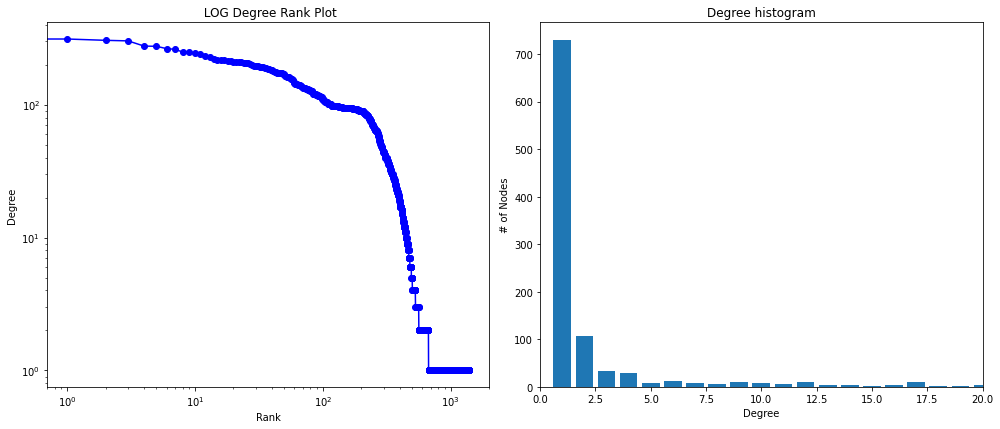

In [16]:
fig = plt.figure("Degree of a graph", figsize=(14, 14))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

#Degree rank plot
ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title(" LOG Degree Rank Plot")
ax1.set_ylabel("Degree")
plt.xscale("log")
plt.yscale("log")
ax1.set_xlabel("Rank")

#Degree histogram
ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")
ax2.set_xlim(0,20)

fig.tight_layout()

plt.show()

### In - out degree

In [17]:
  in_degrees = G.in_degree()
  print(in_degrees)

  out_degrees = G.out_degree()
  out_degrees

[('B001H53QE4', 0), ('B005ESMEBQ', 16), ('B007EE5WNA', 5), ('B007EE5OBU', 3), ('B07HJHK8Y5', 164), ('B016CDNMMG', 45), ('B07193NQ2P', 97), ('B0153R37XQ', 37), ('B01N5TMK8I', 219), ('B004Q7CK9M', 0), ('B01I4AHZXC', 67), ('B01E4QQAWW', 91), ('B01K8RJDEI', 194), ('B005ESMF5G', 5), ('B071VCQJ24', 109), ('B072BGQ8RR', 63), ('B01K8RL0AI', 189), ('B0725JM87R', 83), ('B07DDDS9R4', 36), ('B07FKK8SFR', 23), ('B01JQSONCC', 28), ('B07FMK2JQ8', 47), ('B0719C5P56', 197), ('B06WVJBLBQ', 187), ('B01IE42ST4', 17), ('B01K8RK2KW', 71), ('B07641DGK2', 19), ('B072F9T6VX', 27), ('B01C9MW8Z6', 50), ('B07DD6YZ7H', 19), ('B0763VZ9Z7', 29), ('B00NVUDIZ0', 249), ('B01K8RL9C2', 30), ('1542978645', 1), ('B005SPESKK', 2), ('B01K8RMDO0', 201), ('B00A69H9U4', 2), ('B07G7T21ZY', 5), ('B00171WXII', 1), ('B07KQVLSTN', 1), ('B00NEO5UTU', 1), ('B076CXY1MN', 213), ('B01JQSP498', 20), ('B06XJ35FG4', 1), ('B00BRHSCLE', 1), ('B0777P949T', 1), ('B01N42JV9H', 1), ('B01I5MPR1G', 1), ('B06ZY43PDR', 40), ('0763642649', 1), ('03743

OutDegreeView({'B001H53QE4': 8, 'B005ESMEBQ': 0, 'B007EE5WNA': 0, 'B007EE5OBU': 0, 'B07HJHK8Y5': 0, 'B016CDNMMG': 97, 'B07193NQ2P': 0, 'B0153R37XQ': 0, 'B01N5TMK8I': 0, 'B004Q7CK9M': 61, 'B01I4AHZXC': 0, 'B01E4QQAWW': 0, 'B01K8RJDEI': 0, 'B005ESMF5G': 94, 'B071VCQJ24': 0, 'B072BGQ8RR': 0, 'B01K8RL0AI': 0, 'B0725JM87R': 0, 'B07DDDS9R4': 0, 'B07FKK8SFR': 0, 'B01JQSONCC': 0, 'B07FMK2JQ8': 0, 'B0719C5P56': 0, 'B06WVJBLBQ': 0, 'B01IE42ST4': 0, 'B01K8RK2KW': 0, 'B07641DGK2': 0, 'B072F9T6VX': 0, 'B01C9MW8Z6': 0, 'B07DD6YZ7H': 0, 'B0763VZ9Z7': 0, 'B00NVUDIZ0': 0, 'B01K8RL9C2': 0, '1542978645': 0, 'B005SPESKK': 0, 'B01K8RMDO0': 0, 'B00A69H9U4': 0, 'B07G7T21ZY': 0, 'B00171WXII': 0, 'B07KQVLSTN': 0, 'B00NEO5UTU': 0, 'B076CXY1MN': 0, 'B01JQSP498': 0, 'B06XJ35FG4': 0, 'B00BRHSCLE': 0, 'B0777P949T': 0, 'B01N42JV9H': 0, 'B01I5MPR1G': 0, 'B06ZY43PDR': 0, '0763642649': 0, '0374300216': 0, '0385376715': 0, 'B001IXYOD2': 0, '0811879542': 0, 'B00X22L0AC': 0, 'B01MFFVSU8': 0, 'B073XZRV9Z': 0, 'B00HB0WGL8':

### Centrality & other stuff
(from exercises)


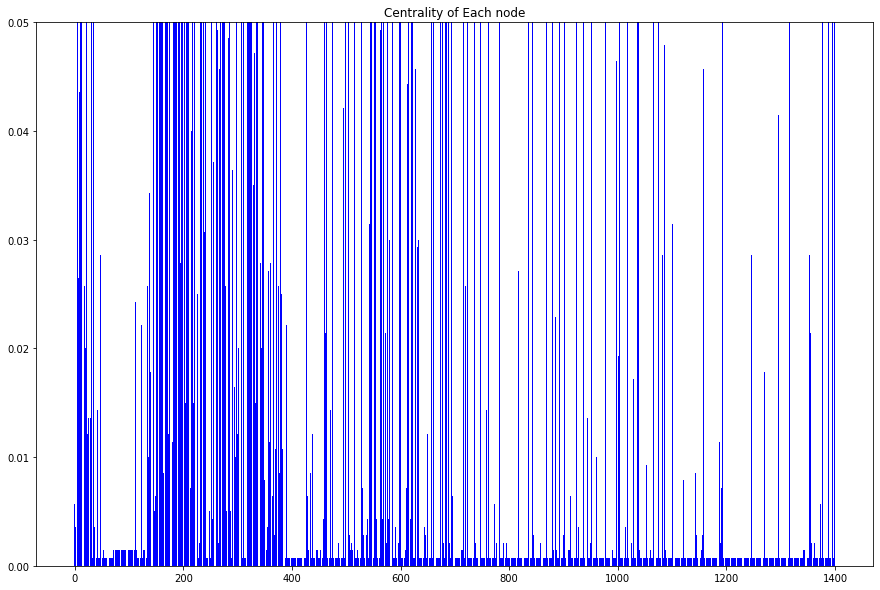

In [18]:

#Centrality of the Nodes.
degree_central=nx.degree_centrality(G)
plt.bar(range(len(degree_central)),degree_central.values(),width=0.8, color='b')
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
axes.set_ylim([0,0.05])
plt.title("Centrality of Each node")
plt.show()



In [26]:
def centrality_study(G): 
  degree = nx.degree_centrality
  pagerank= nx.pagerank(G, alpha=0.85)
  closeness = nx.closeness_centrality(G)
  betweenness = nx.betweenness_centrality(G)
  eingeigenvector = nx.eigenvector_centrality(G)
  harmonic = nx.harmonic_centrality(G)
  return degree, pagerank, closeness, betweenness, eingeigenvector, harmonic



In [30]:
degree, pagerank, closeness, betweenness, eingeigenvector, harmonic = centrality_study(G)

"\nplt.subplot(322)\ndraw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')\n\n\nplt.subplot(323)\ndraw(G, pos, nx.harmonic_centrality(G), 'Harmonic Centrality')\n\nplt.subplot(324)\ndraw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')\n\nplt.subplot(325)\ndraw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')\n\nplt.subplot(326)\ndraw(G, pos, nx.degree_centrality(G), 'Degree Centrality')\n"

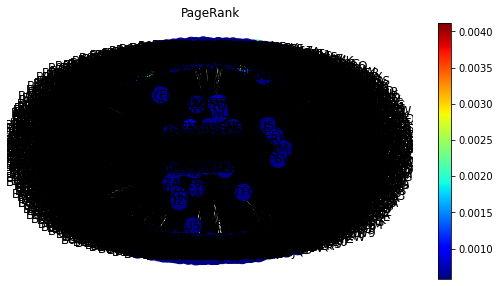

In [31]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=280, cmap=plt.cm.jet, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    #nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    #plt.show()
    
pos = nx.spring_layout(G)

plt.figure(figsize=(20, 16)) 
plt.subplot(321)
draw(G, pos, pagerank, 'PageRank')

"""
plt.subplot(322)
draw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')


plt.subplot(323)
draw(G, pos, nx.harmonic_centrality(G), 'Harmonic Centrality')

plt.subplot(324)
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

plt.subplot(325)
draw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')

plt.subplot(326)
draw(G, pos, nx.degree_centrality(G), 'Degree Centrality')
"""